In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

In [3]:
df = spark.read.csv('rotten_tomatoes_movies.csv', header=True, inferSchema=True)

In [4]:
df.show(10)

+--------------------+--------------------+-------------+-----------+------+--------------------+-------------------+--------------------+--------------+--------------------+----------------+--------------------+--------------------+---------+-----------+--------+
|                  id|               title|audienceScore|tomatoMeter|rating|      ratingContents|releaseDateTheaters|releaseDateStreaming|runtimeMinutes|               genre|originalLanguage|            director|              writer|boxOffice|distributor|soundMix|
+--------------------+--------------------+-------------+-----------+------+--------------------+-------------------+--------------------+--------------+--------------------+----------------+--------------------+--------------------+---------+-----------+--------+
|  space-zombie-bingo| Space Zombie Bingo!|           50|       NULL|  NULL|                NULL|               NULL|          2018-08-25|            75|Comedy, Horror, S...|         English|       George 

In [5]:
missing_values = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in ['audienceScore', 'tomatoMeter', 'releaseDateTheaters']])
missing_values.show(vertical=True)

-RECORD 0---------------------
 audienceScore       | 70010  
 tomatoMeter         | 109381 
 releaseDateTheaters | 112485 



In [6]:
df = df.na.drop(subset=['audienceScore', 'tomatoMeter', 'releaseDateTheaters'])

In [7]:
missing_values = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in ['audienceScore', 'tomatoMeter', 'releaseDateTheaters']])
missing_values.show(vertical=True)

-RECORD 0------------------
 audienceScore       | 0   
 tomatoMeter         | 0   
 releaseDateTheaters | 0   



In [8]:
df = df.withColumn('year', F.year(df.releaseDateTheaters))

In [9]:
df.select('year').show()

+----+
|year|
+----+
|2018|
|1947|
|2009|
|2011|
|2005|
|2017|
|1963|
|1996|
|2009|
|1991|
|2002|
|2017|
|2022|
|2015|
|1993|
|2012|
|2019|
|2017|
|2014|
|2004|
+----+
only showing top 20 rows



In [10]:
df = df.orderBy(F.desc('tomatoMeter'), F.asc('title')).limit(5000)

In [11]:
df.select(['tomatoMeter', 'title']).show()

+-----------+--------------------+
|tomatoMeter|               title|
+-----------+--------------------+
|        100|"J.R. ""Bob"" Dob...|
|        100|                 '96|
|        100|100 Years of Men ...|
|        100|               11:55|
|        100|        12 Angry Men|
|        100|            16 Acres|
|        100|2022 Oscar Nomina...|
|        100|                2LDK|
|        100|                  36|
|        100|      4 Little Girls|
|        100|             5-25-77|
|        100|                  5B|
|        100|             76 Days|
|        100|     99 River Street|
|        100|  A Beautiful Planet|
|        100|     A Bigger Splash|
|        100|    A Brother's Kiss|
|        100|   A Christmas Carol|
|        100|   A City of Sadness|
|        100|A Crime on the Bayou|
+-----------+--------------------+
only showing top 20 rows



In [12]:
df.write.parquet('movies.parquet', mode='overwrite')

In [13]:
df = pd.read_parquet('movies.parquet')
df.head()

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix,year
0,jr_bob_dobbs_and_the_church_of_the_subgenius,"""J.R. """"Bob"""" Dobbs & The Church of the SubGen...",36,100,None,None,2020-10-16,2020-10-20,80.0,"Documentary, Comedy",English,Sandy K. Boone,"Sandy K. Boone,Jason Wehling",None,Dark Star Pictures,None,2020
1,96,'96,89,100,None,None,2018-10-03,None,158.0,Romance,Tamil,C. Premkumar,C. Premkumar,$234.2K,None,None,2018
2,100_years_of_men_in_love,100 Years of Men in Love: The Accidental Colle...,55,100,None,None,2022-03-23,2022-03-25,57.0,"Documentary, History, Lgbtq+",English,David Millbern,David Millbern,None,Here TV,None,2022
3,1155,11:55,80,100,None,None,2017-06-09,2017-06-09,80.0,"Crime, Drama",English,"Ari Issler,Ben Snyder","Victor Almanzar,Ari Issler,Ben Snyder",None,Gravitas Ventures,None,2017
4,1000013_12_angry_men,12 Angry Men,97,100,None,None,1957-04-20,2008-03-04,95.0,Drama,English,Sidney Lumet,Reginald Rose,None,"Criterion Collection, MGM/UA Home Entertainmen...",None,1957


Text(0.5, 1.0, 'Audience Score vs Tomato Meter')

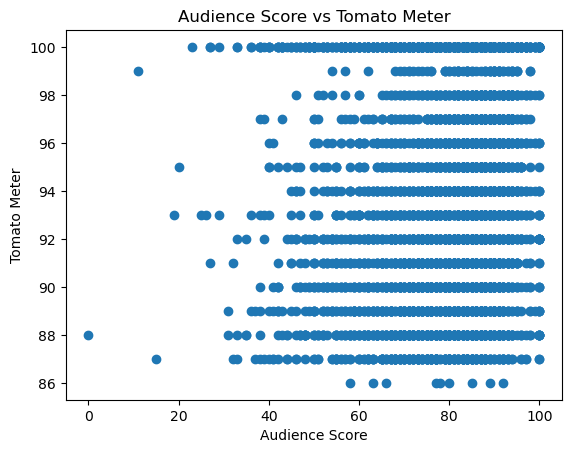

In [14]:
fig, ax = plt.subplots()
ax.scatter(x=df.audienceScore, y=df.tomatoMeter)
ax.set_xlabel('Audience Score')
ax.set_ylabel('Tomato Meter')
plt.title('Audience Score vs Tomato Meter')

In [15]:
avg_score_year = df.groupby('year')[['tomatoMeter', 'audienceScore']].mean().reset_index()
avg_score_year

,year,tomatoMeter,audienceScore
0,1902,100.000000,90.000000
1,1914,90.000000,42.000000
2,1915,93.666667,56.666667
3,1916,93.000000,78.500000
4,1919,95.000000,69.000000
...,...,...,...
104,2019,94.333333,76.890244
105,2020,93.765517,74.889655
106,2021,94.415638,75.637860
107,2022,94.167382,79.283262


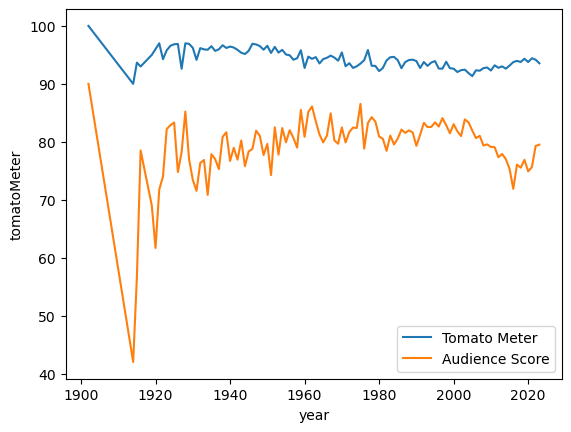

In [16]:
sns.lineplot(data=avg_score_year, x='year', y='tomatoMeter', label='Tomato Meter')
sns.lineplot(data=avg_score_year, x='year', y='audienceScore', label='Audience Score')
plt.legend()

In [17]:
score_by_language = df.groupby('originalLanguage')[['tomatoMeter', 'audienceScore']].mean().reset_index()
score_by_language = score_by_language.loc[score_by_language['originalLanguage'].isin(['Arabic', 'Yiddish', 'English', 'Chinese', 'Spanish', 'French'])]
score_by_language

,originalLanguage,tomatoMeter,audienceScore
2,Arabic,93.893617,81.021277
9,Chinese,93.917526,79.402062
15,English,93.734092,78.606246
21,French,94.000000,92.000000
61,Spanish,93.415842,75.722772
76,Yiddish,97.500000,64.500000


In [19]:
languages_melted = pd.melt(score_by_language, id_vars=['originalLanguage'], value_vars=['tomatoMeter', 'audienceScore'], var_name='type', value_name='score')
languages_melted

,originalLanguage,type,score
0,Arabic,tomatoMeter,93.893617
1,Chinese,tomatoMeter,93.917526
2,English,tomatoMeter,93.734092
3,French,tomatoMeter,94.000000
4,Spanish,tomatoMeter,93.415842
5,Yiddish,tomatoMeter,97.500000
6,Arabic,audienceScore,81.021277
7,Chinese,audienceScore,79.402062
8,English,audienceScore,78.606246
9,French,audienceScore,92.000000


<Axes: xlabel='originalLanguage', ylabel='score'>

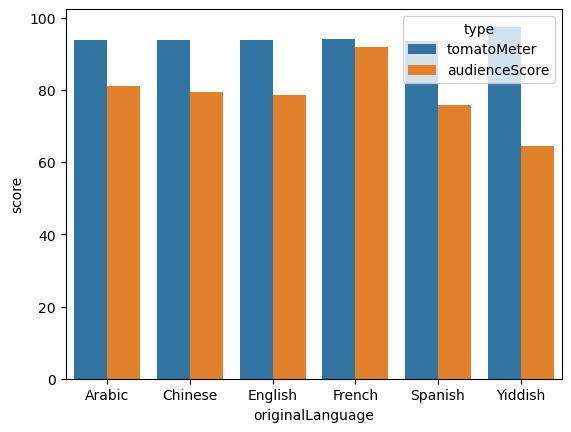

In [21]:
sns.barplot(data=languages_melted, x='originalLanguage', y='score', hue='type')